<a id="0"></a> <br>
# 1. Environment

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import keras
from keras.models import Sequential

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

<a id="1"></a> <br>
# 2. Data cleaning and Explore data
## 2.1 Data overview and cleaning

In [2]:
path = '../input/har-dataset/'

In [3]:
csv_files = [ '1.csv','2.csv','3.csv','4.csv','5.csv',
             '6.csv','7.csv','8.csv','9.csv','10.csv',
             '11.csv','12.csv','13.csv','14.csv','15.csv']

In [4]:
all_dataset = []

for file in csv_files:
    temp = pd.read_csv(path + file)
    temp.columns = ['index', 'x', 'y', 'z', 'activity']
    temp = temp.drop(['index'], axis=1)
    all_dataset.append(temp)

In [5]:
def plot_acc(df,title=None,ylim=(1000,3000)):
    t = df.index/52
    plt.figure(figsize=(18,3))
    plt.plot(t, df[['x','y','z']]);
    if ylim:
        plt.ylim(ylim)
    changes_i = np.insert(np.argwhere(df.activity.values[:-1] - df.activity.values[1:]).reshape(-1), 0, 0)
    changes = changes_i/52
    changes_c =[df.activity.iloc[i+1] for i in changes_i]
    text_p = 0.1*plt.gca().get_ylim()[1]+0.9*plt.gca().get_ylim()[0]
    for i,i_t in enumerate(changes[:-1]):
        plt.axvline(x=i_t,color='r',ls='--')
        plt.text(x=(i_t+changes[i+1])/2, y=text_p, s=str(changes_c[i]),
                 horizontalalignment='center',color='k',fontsize=20)
    plt.axvline(x=max(t),color='r',ls='--')
    if title:
        plt.title(title,fontsize = 20);
    plt.show()

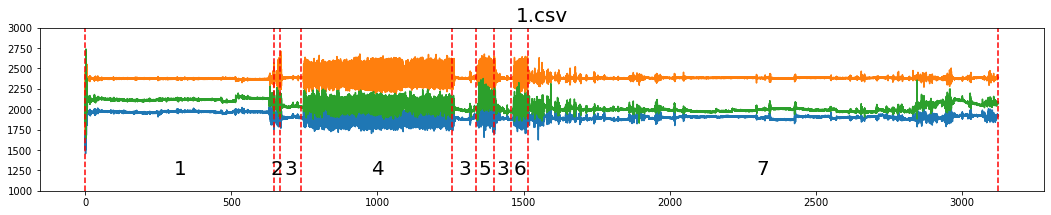

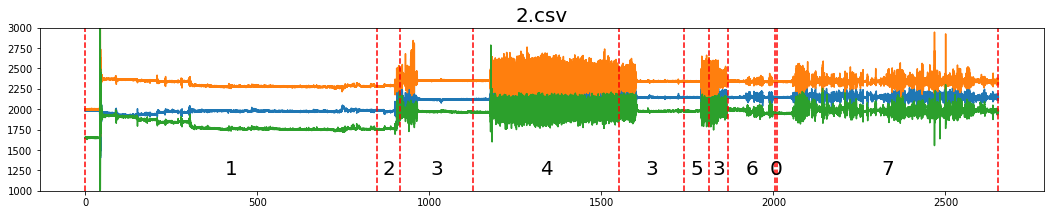

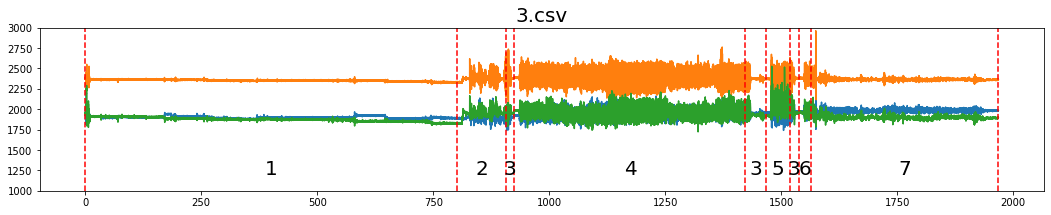

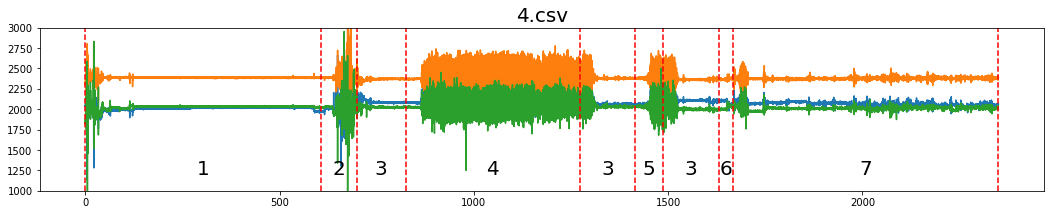

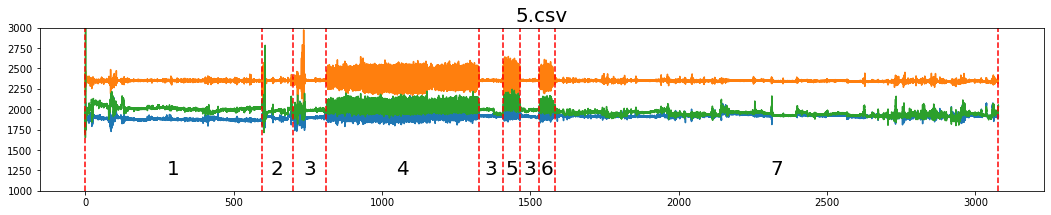

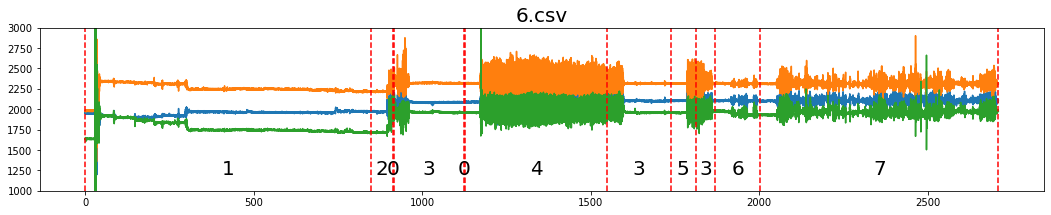

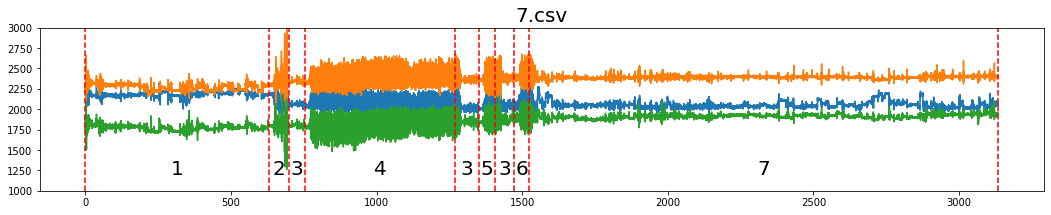

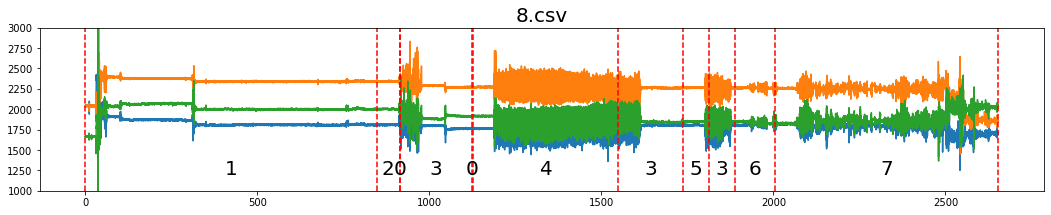

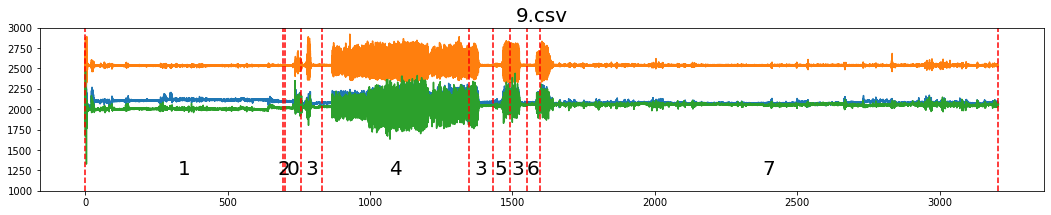

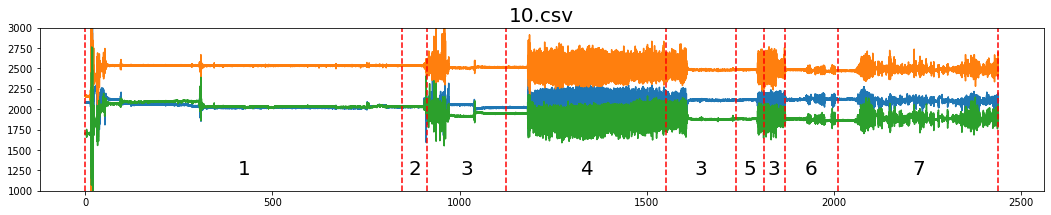

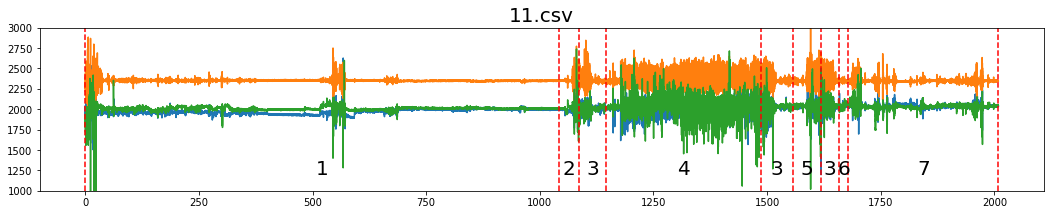

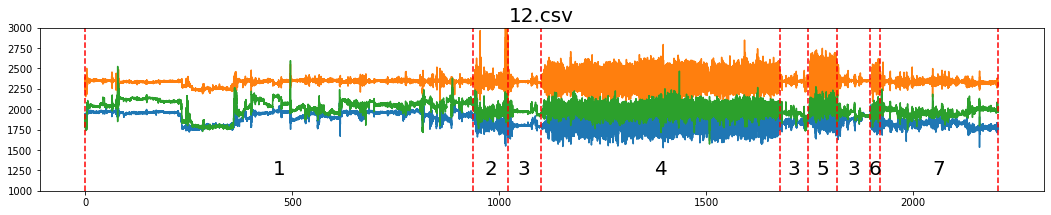

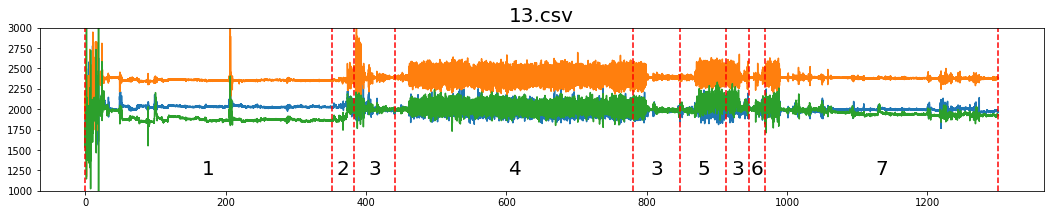

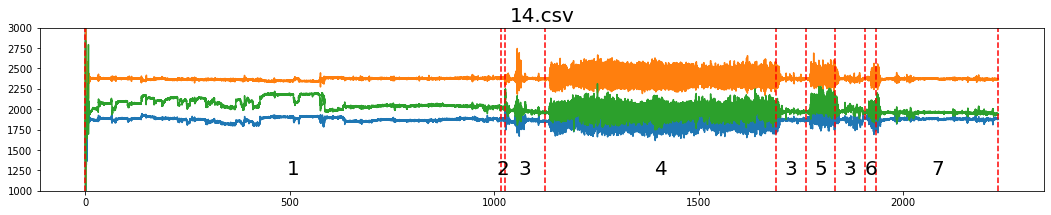

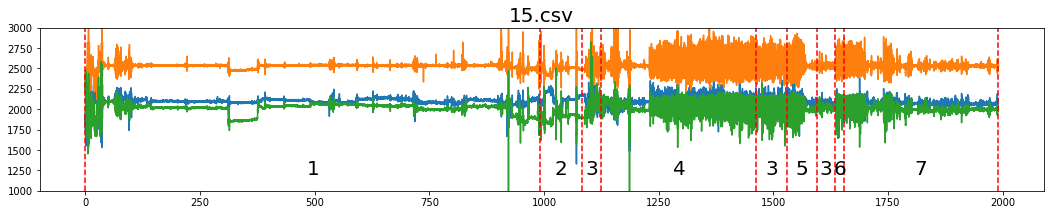

In [6]:
# lets check how these acceleration history looks like
for df,f_name in zip(all_dataset,csv_files):
    plot_acc(df,f_name)

Blue, green and orange lines are corresponding to the x,y,z acceleration histories. The red dash line indicates the transition between different activities (encoded number shown on graph). Here come some observations.
1. There are only a few data missing (the sequence number is slightly larger than the value counts, and some data has a label 0). Considering the fact that there are quite sufficient data (a signal file contents over 100k rows), the missing data are dropped and ignored. (This is safe as acceleration is a transient quantity, physically speaking)
2. The acceleration data is not calibrated (have an offset and the unit is unknown).
3. There is a very large spike in all the data at the very beginning, maybe is due to the setup of the device. I manually cut off the spike at begining.
4.  '5.csv' shows very intuitive labels. When the person moves, there is an immediate response on the acceleration reading. Labels in other files are not very intuitive. The activity transitions (labels) seem to have a delay, compared with the change in acceleration readings. This could be a mistake in the label or preprocessing part, I manually shifted the labels for each file.

In [7]:
cut_dict = { '1.csv':[400,400],
             '2.csv':[2600,20000],
             '3.csv':[650,2000],
             '4.csv':[1900,10000],
             '5.csv':[0,200],
             '6.csv':[2500,20000],
             '7.csv':[1000,3000],
             '8.csv':[3200,20000],
             '9.csv':[1800,3000],
             '10.csv':[3000,20000],
             '11.csv':[1500,2000],
             '12.csv':[550,3000],
             '13.csv':[1000,2000],
             '14.csv':[600,2000],
             '15.csv':[5500,10000]}

In [8]:
def align_and_cut(df_in,align = 0, cut= 0):
    df = df_in.copy()
    df.activity = np.pad(df.activity[:len(df)-align],(align,0),mode ='edge')
    df = df[cut:]
    df = df[df.activity!=0].reset_index(drop=True)
    df.iloc[len(df)-1,3]=0 #flag at the end
    return df

In [9]:
process_data = []
for df,f_name in zip(all_dataset,csv_files):
    ndf = align_and_cut(df,cut_dict[f_name][0],cut_dict[f_name][1])
    process_data.append(ndf)
#     plot_acc(ndf,f_name)

Now I perform a calibration for the accelerometer by subtracting the signal from the mean. Each test (indiviual) have there own offset. In addition, the moving directions seems to be not important in this task (walk left or right, going up and down), and I also don't know the positve/negtive directions about the recording. So after subtracting the mean value, It the mean of all observation value is negtive, I reverse the sign for all the data to make the overall mean a positive number.

In [10]:
mean = {fn:df[df.activity==1][['x','y','z']].mean() for fn, df in enumerate(process_data)}
mean = pd.DataFrame(mean)
mean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
x,1965.044839,1980.517739,1899.502381,2014.474210,1878.346373,1966.504277,2185.255455,1808.599545,2111.101780,2022.879145,1971.235685,1917.492408,2031.760345,1874.443719,2101.860018
y,2374.404680,2280.200531,2352.427140,2385.945902,2351.193931,2237.577791,2271.772188,2340.038841,2535.781392,2535.203335,2351.711882,2332.594678,2357.049424,2370.282550,2526.074672
z,2119.215257,1757.091742,1872.703402,2031.211869,2010.990026,1734.993896,1773.291294,2000.692867,2006.734873,2031.624570,2007.749557,2025.230415,1879.735691,2075.476357,1997.950530


In [11]:
for i, df in enumerate(process_data):
    df.x = df.x - mean.loc['x',i]
    df.y = df.y - mean.loc['y',i]
    df.z = df.z - mean.loc['z',i]

In [12]:
# for df,f_name in zip(process_data,csv_files):    
#     plot_acc(df,f_name, ylim=(-1000,1000))

In [13]:
del all_dataset
gc.collect()

72715

## 2.2 Exploring data
From the previous section, one can tell the activity class is unbalanced, class 1 and 7 are the dominated class when class 2, 5 and 6 are under-represented. Let check the overall class counts among 15 files.

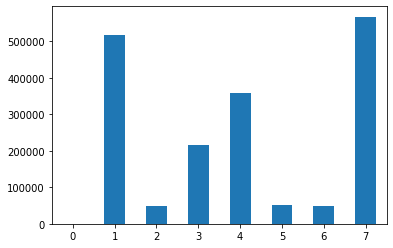

In [14]:
all_targets = pd.concat([df.activity.value_counts() for df in process_data],axis=1).sum(axis=1)
all_targets.plot.bar(rot=0);

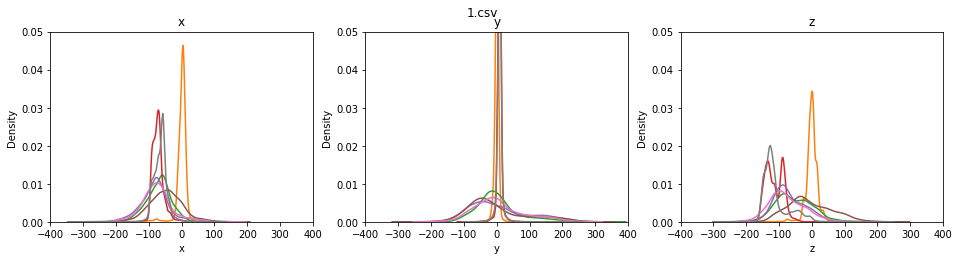

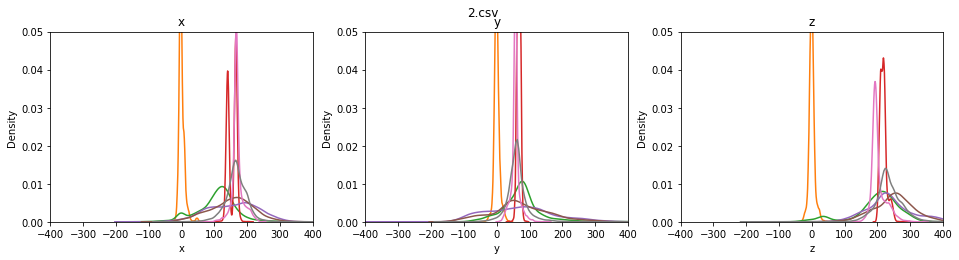

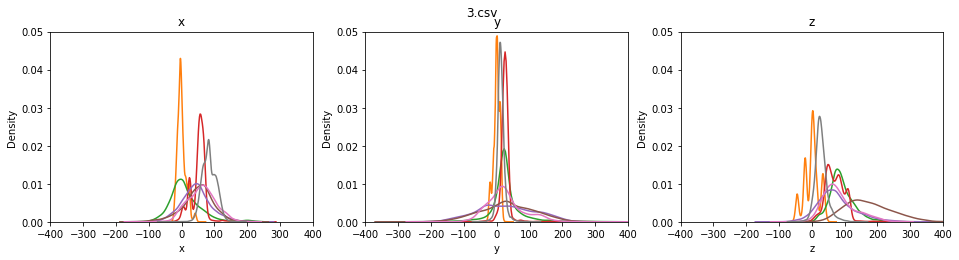

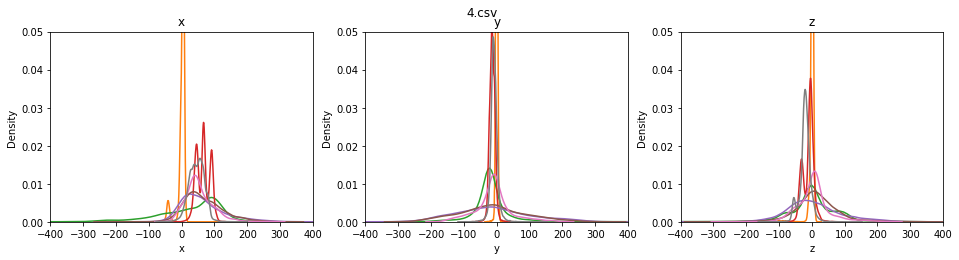

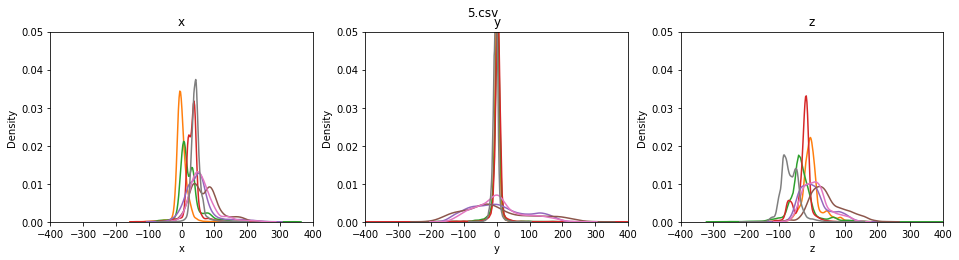

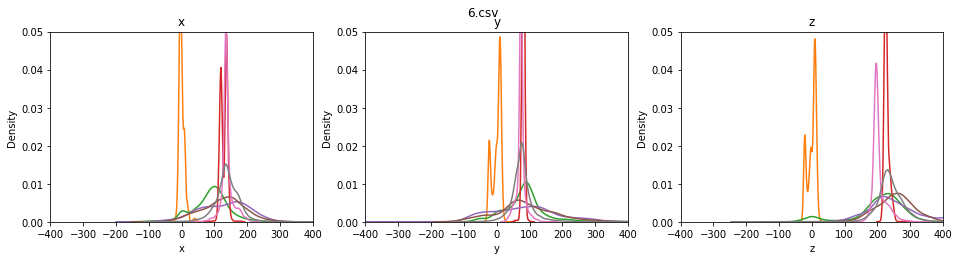

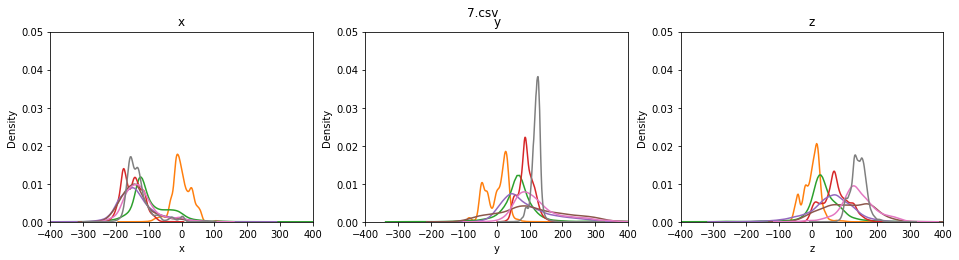

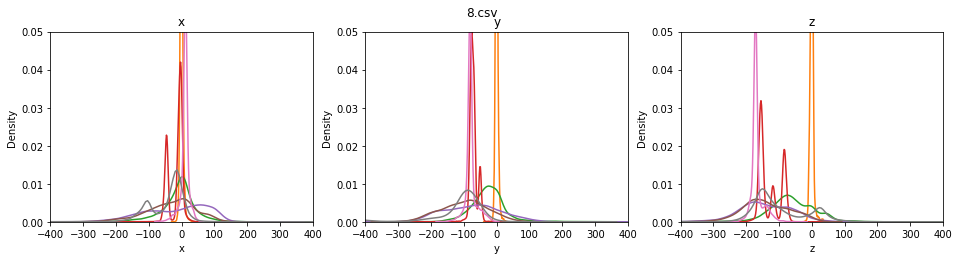

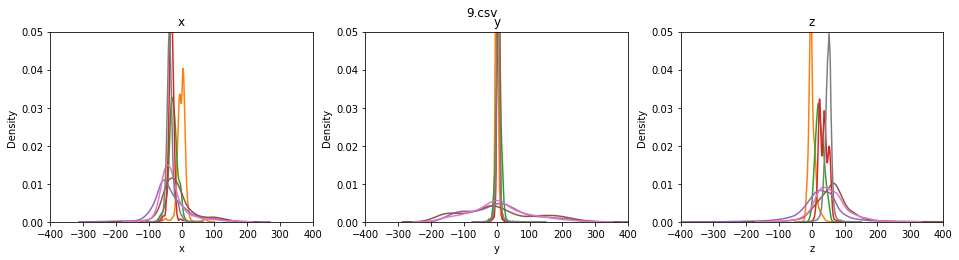

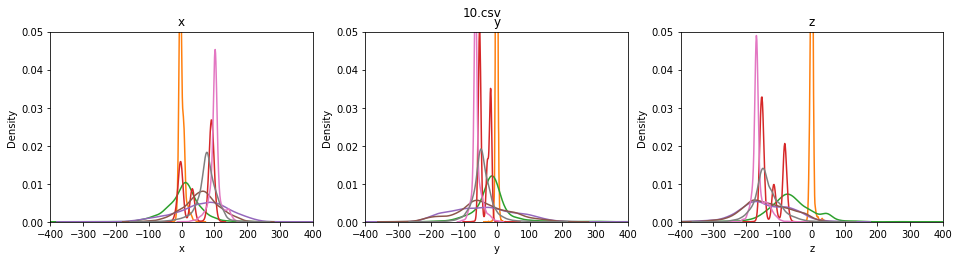

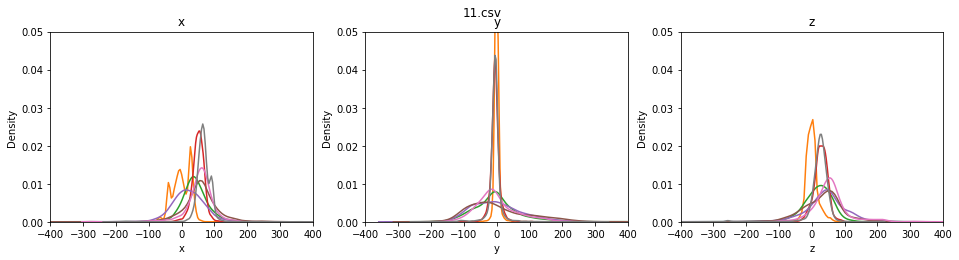

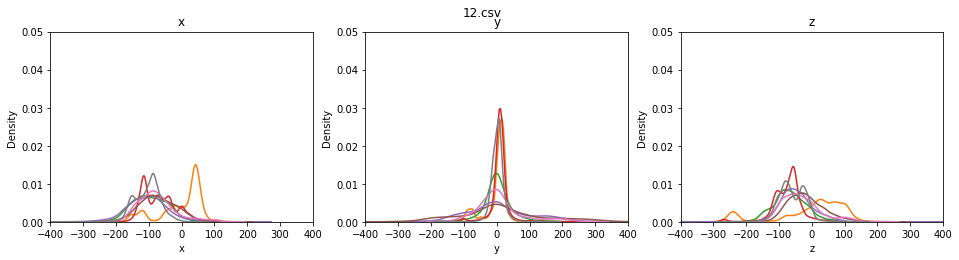

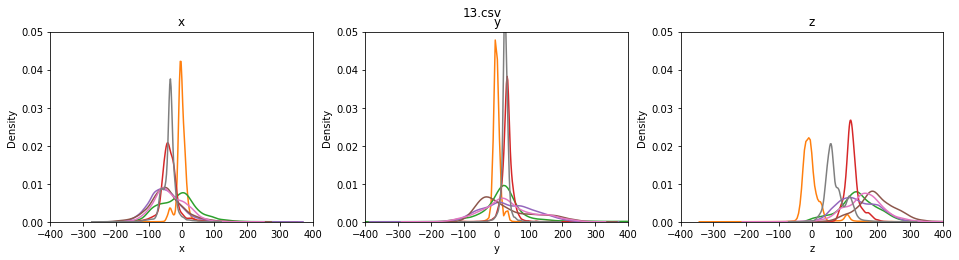

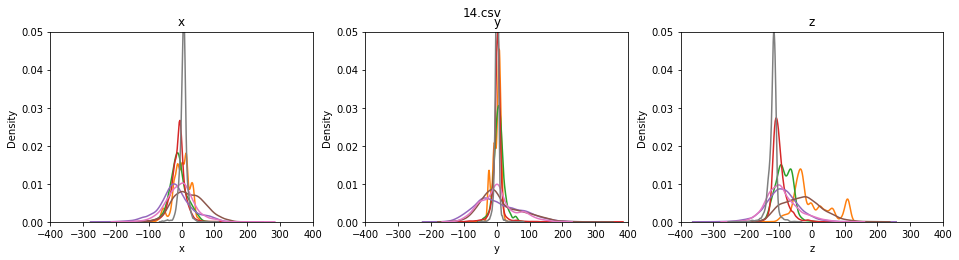

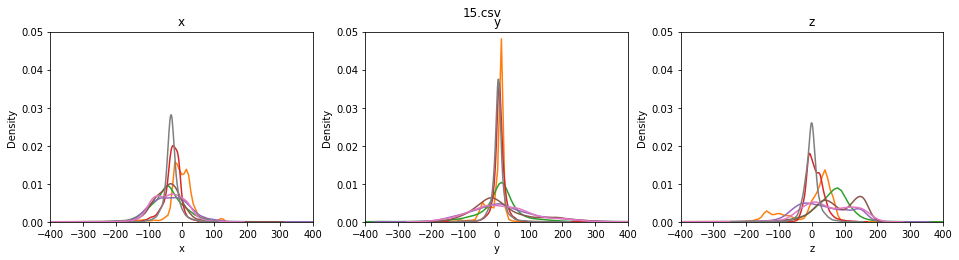

In [15]:
# check the kernal density estimation for each indiviual file/person at each axis 
for i, fname in zip(range(15), csv_files):
    df = process_data[i]
    plt.figure(figsize=[16, 3.5]);
    for c, df_ in df.groupby('activity'):
        for i, col in enumerate(['x','y','z']):
            plt.subplot(1, 3, i+1)
            sns.kdeplot(df_[col], legend= False)
            plt.xlim((-400,400))
            plt.ylim((0,0.05));plt.title(col)
    plt.suptitle(fname);
    plt.show();

From these plot, the standard derivation will be an informative feature.

# 3. Time series analysis and model

In [16]:
def remove_outlier(dataset):
    
    combine = []
    
    for i in range(15):
        df = dataset[i]
        first_quartile_x = df['x'].quantile(0.25)
        third_quartile_x = df['x'].quantile(0.75)        
        low_thres_x = first_quartile_x - 1.5 * (third_quartile_x - first_quartile_x)
        high_thres_x = third_quartile_x + 1.5 * (third_quartile_x - first_quartile_x)
        first_quartile_y = df['y'].quantile(0.25)
        third_quartile_y = df['y'].quantile(0.75)        
        low_thres_y = first_quartile_y - 1.5 * (third_quartile_y - first_quartile_y)
        high_thres_y = third_quartile_y + 1.5 * (third_quartile_y - first_quartile_y)
        first_quartile_z = df['z'].quantile(0.25)
        third_quartile_z = df['z'].quantile(0.75)        
        low_thres_z = first_quartile_z - 1.5 * (third_quartile_z - first_quartile_z)
        high_thres_z = third_quartile_z + 1.5 * (third_quartile_z - first_quartile_z)
        
        df = df.loc[(df['x']>=low_thres_x) & (df['x']<=high_thres_x)
                   & (df['y']>=low_thres_y) & (df['y']<=high_thres_y)
                   & (df['z']>=low_thres_z) & (df['z']<=high_thres_z)]
        
        combine.append(df)
        
    return combine

In [17]:
def normalize(dataset):
    
    df = dataset
    
    for i in df.columns:
        if i != 'activity':
            df_mean = df[i].mean()
            df_std = df[i].std()
            df[i] = (df[i] - df_mean)/df_std        
    
    return df

In [18]:
def make_ts_features(dataset, window):
    
    combine = []
    shift = [0]
    
    for i in tqdm(range(15)):
        df = dataset[i]
        for i in ['x','y','z']:
            for j in shift:              
                df[i+'_mean_shift_'+str(j)] = df[i].transform(lambda x: x.shift(j).rolling(window).mean())                
                df[i+'_std_shift_'+str(j)] = df[i].transform(lambda x: x.shift(j).rolling(window).std())                
                df[i+'_max_shift_'+str(j)] = df[i].transform(lambda x: x.shift(j).rolling(window).max())                
                df[i+'_min_shift_'+str(j)] = df[i].transform(lambda x: x.shift(j).rolling(window).min())
                df[i+'_skew_shift_'+str(j)] = df[i].transform(lambda x: x.shift(j).rolling(window).skew(axis=1))
                df[i+'_kurtosis_shift_'+str(j)] = df[i].transform(lambda x: x.shift(j).rolling(window).kurt(axis=1))
                
        df = df.dropna()
        combine.append(df)
    
    return combine

## 3.1 Window size = 25

In [19]:
data_w25 = remove_outlier(process_data)
data_w25 = make_ts_features(process_data, window=25)

100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


In [20]:
train1 = data_w25[0]
train2 = data_w25[1]
train3 = data_w25[2]
train4 = data_w25[3]
train5 = data_w25[4]
train6 = data_w25[5]
train7 = data_w25[6]
train8 = data_w25[7]
train9 = data_w25[8]
train10 = data_w25[9]
train11 = data_w25[10]
train12 = data_w25[11]
train13 = data_w25[12]
train14 = data_w25[13]
train15 = data_w25[14]
train_set = pd.concat((train1, train2, train3, train4, train5, train6,
                     train7, train8, train9, train10, train11, train12,
                     train13, train14, train15))
train_set = train_set.loc[train_set.activity !=0]

In [21]:
train_set = normalize(train_set)

In [22]:
Xtrain = train_set.drop(['activity'], axis=1)
Ytrain = train_set['activity']

In [23]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [24]:
TIME_STEPS = 100 # larger number, better val acc 200 is good
STEP = 20

X_train, y_train = create_dataset(
    Xtrain,
    Ytrain,
    TIME_STEPS,
    STEP
)

In [25]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)

In [26]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,          
          input_shape=[X_train.shape[1], X_train.shape[2]],
#           input_shape=[1, col],
#           recurrent_dropout=0.3
          return_sequences=True
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=64          
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',  
  optimizer='adam',
  metrics=['acc']
)

2021-12-01 20:13:36.217881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:13:36.324809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:13:36.325556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:13:36.326644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
#     validation_data=(X_val, y_val)
)

2021-12-01 20:13:39.001899: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 606513600 exceeds 10% of free system memory.
2021-12-01 20:13:39.651273: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 606513600 exceeds 10% of free system memory.
2021-12-01 20:13:40.109763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-01 20:13:46.283367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2257/2257 [==============================] - 60s 23ms/step - loss: 0.8347 - acc: 0.8004 - val_loss: 1.5442 - val_acc: 0.5940
Epoch 2/20
2257/2257 [==============================] - 51s 23ms/step - loss: 0.7943 - acc: 0.7697 - val_loss: 1.3556 - val_acc: 0.6088
Epoch 3/20
2257/2257 [==============================] - 51s 23ms/step - loss: 0.8106 - acc: 0.7722 - val_loss: 1.5210 - val_acc: 0.6236
Epoch 4/20
2257/2257 [==============================] - 51s 23ms/step - loss: 0.7383 - acc: 0.7976 - val_loss: 1.3999 - val_acc: 0.6375
Epoch 5/20
2257/2257 [==============================] - 51s 23ms/step - loss: 0.7161 - acc: 0.7915 - val_loss: 1.5368 - val_acc: 0.6263
Epoch 6/20
2257/2257 [==============================] - 52s 23ms/step - loss: 0.6802 - acc: 0.7968 - val_loss: 1.2865 - val_acc: 0.6399
Epoch 7/20
2257/2257 [==============================] - 52s 23ms/step - loss: 0.7414 - acc: 0.7698 - val_loss: 1.1320 - val_acc: 0.6786
Epoch 8/20
2257/2257 [==============================] - 52s

## 3.2 Window size = 50

In [28]:
data_w50 = remove_outlier(process_data)
data_w50 = make_ts_features(process_data, window=50)

100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


In [29]:
train1 = data_w50[0]
train2 = data_w50[1]
train3 = data_w50[2]
train4 = data_w50[3]
train5 = data_w50[4]
train6 = data_w50[5]
train7 = data_w50[6]
train8 = data_w50[7]
train9 = data_w50[8]
train10 = data_w50[9]
train11 = data_w50[10]
train12 = data_w50[11]
train13 = data_w50[12]
train14 = data_w50[13]
train15 = data_w50[14]
train_set = pd.concat((train1, train2, train3, train4, train5, train6,
                     train7, train8, train9, train10, train11, train12,
                     train13, train14, train15))
train_set = train_set.loc[train_set.activity !=0]

In [30]:
train_set = normalize(train_set)

In [31]:
Xtrain = train_set.drop(['activity'], axis=1)
Ytrain = train_set['activity']

In [32]:
TIME_STEPS = 100 # larger number, better val acc 200 is good
STEP = 20

X_train, y_train = create_dataset(
    Xtrain,
    Ytrain,
    TIME_STEPS,
    STEP
)

In [33]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)

In [34]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,          
          input_shape=[X_train.shape[1], X_train.shape[2]],
#           input_shape=[1, col],
#           recurrent_dropout=0.3
          return_sequences=True
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=64          
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',  
  optimizer='adam',
  metrics=['acc']
)

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
#     validation_data=(X_val, y_val)
)

2021-12-01 20:32:45.413508: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 606387600 exceeds 10% of free system memory.
2021-12-01 20:32:46.088142: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 606387600 exceeds 10% of free system memory.


Epoch 1/20
2256/2256 [==============================] - 58s 23ms/step - loss: 0.9088 - acc: 0.7743 - val_loss: 1.5575 - val_acc: 0.4925
Epoch 2/20
2256/2256 [==============================] - 53s 23ms/step - loss: 0.8354 - acc: 0.7713 - val_loss: 1.5064 - val_acc: 0.6227
Epoch 3/20
2256/2256 [==============================] - 51s 23ms/step - loss: 0.8008 - acc: 0.7767 - val_loss: 1.2196 - val_acc: 0.6421
Epoch 4/20
2256/2256 [==============================] - 52s 23ms/step - loss: 0.7817 - acc: 0.7737 - val_loss: 1.3565 - val_acc: 0.6227
Epoch 5/20
2256/2256 [==============================] - 51s 23ms/step - loss: 0.7753 - acc: 0.7726 - val_loss: 1.2709 - val_acc: 0.5782
Epoch 6/20
2256/2256 [==============================] - 52s 23ms/step - loss: 0.7502 - acc: 0.7905 - val_loss: 1.2352 - val_acc: 0.6213
Epoch 7/20
2256/2256 [==============================] - 52s 23ms/step - loss: 0.7425 - acc: 0.7741 - val_loss: 1.5486 - val_acc: 0.6118
Epoch 8/20
2256/2256 [==========================

## 3.3 Window size = 100

In [36]:
data_w100 = remove_outlier(process_data)
data_w100 = make_ts_features(process_data, window=100)

100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


In [37]:
train1 = data_w100[0]
train2 = data_w100[1]
train3 = data_w100[2]
train4 = data_w100[3]
train5 = data_w100[4]
train6 = data_w100[5]
train7 = data_w100[6]
train8 = data_w100[7]
train9 = data_w100[8]
train10 = data_w100[9]
train11 = data_w100[10]
train12 = data_w100[11]
train13 = data_w100[12]
train14 = data_w100[13]
train15 = data_w100[14]
train_set = pd.concat((train1, train2, train3, train4, train5, train6,
                     train7, train8, train9, train10, train11, train12,
                     train13, train14, train15))
train_set = train_set.loc[train_set.activity !=0]

In [38]:
train_set = normalize(train_set)

In [39]:
Xtrain = train_set.drop(['activity'], axis=1)
Ytrain = train_set['activity']

In [40]:
TIME_STEPS = 100 # larger number, better val acc 200 is good
STEP = 20

X_train, y_train = create_dataset(
    Xtrain,
    Ytrain,
    TIME_STEPS,
    STEP
)

In [41]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)

In [42]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,          
          input_shape=[X_train.shape[1], X_train.shape[2]],
#           input_shape=[1, col],
#           recurrent_dropout=0.3
          return_sequences=True
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=64          
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',  
  optimizer='adam',
  metrics=['acc']
)

In [43]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
#     validation_data=(X_val, y_val)
)

2021-12-01 20:53:09.583929: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 606135600 exceeds 10% of free system memory.


Epoch 1/20
2255/2255 [==============================] - 58s 23ms/step - loss: 0.8498 - acc: 0.7848 - val_loss: 1.6744 - val_acc: 0.5952
Epoch 2/20
2255/2255 [==============================] - 51s 23ms/step - loss: 0.9466 - acc: 0.7424 - val_loss: 1.3649 - val_acc: 0.5244
Epoch 3/20
2255/2255 [==============================] - 53s 23ms/step - loss: 0.8492 - acc: 0.7631 - val_loss: 1.1467 - val_acc: 0.6286
Epoch 4/20
2255/2255 [==============================] - 51s 23ms/step - loss: 0.8457 - acc: 0.7648 - val_loss: 1.2666 - val_acc: 0.6192
Epoch 5/20
2255/2255 [==============================] - 53s 24ms/step - loss: 0.8318 - acc: 0.7623 - val_loss: 1.3908 - val_acc: 0.6049
Epoch 6/20
2255/2255 [==============================] - 52s 23ms/step - loss: 0.7718 - acc: 0.7759 - val_loss: 1.2969 - val_acc: 0.6261
Epoch 7/20
2255/2255 [==============================] - 50s 22ms/step - loss: 0.7188 - acc: 0.7922 - val_loss: 1.3296 - val_acc: 0.6444
Epoch 8/20
2255/2255 [==========================

## 3.4 Window size = 200

In [44]:
data_w200 = remove_outlier(process_data)
data_w200 = make_ts_features(process_data, window=200)

100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


In [45]:
train1 = data_w200[0]
train2 = data_w200[1]
train3 = data_w200[2]
train4 = data_w200[3]
train5 = data_w200[4]
train6 = data_w200[5]
train7 = data_w200[6]
train8 = data_w200[7]
train9 = data_w200[8]
train10 = data_w200[9]
train11 = data_w200[10]
train12 = data_w200[11]
train13 = data_w200[12]
train14 = data_w200[13]
train15 = data_w200[14]
train_set = pd.concat((train1, train2, train3, train4, train5, train6,
                     train7, train8, train9, train10, train11, train12,
                     train13, train14, train15))
train_set = train_set.loc[train_set.activity !=0]

In [46]:
train_set = normalize(train_set)

In [47]:
Xtrain = train_set.drop(['activity'], axis=1)
Ytrain = train_set['activity']

In [48]:
TIME_STEPS = 100 # larger number, better val acc 200 is good
STEP = 20

X_train, y_train = create_dataset(
    Xtrain,
    Ytrain,
    TIME_STEPS,
    STEP
)

In [49]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)

In [50]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,          
          input_shape=[X_train.shape[1], X_train.shape[2]],
#           input_shape=[1, col],
#           recurrent_dropout=0.3
          return_sequences=True
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=64          
      )
    )
)
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',  
  optimizer='adam',
  metrics=['acc']
)

In [51]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
#     validation_data=(X_val, y_val)
)

Epoch 1/20
2254/2254 [==============================] - 58s 23ms/step - loss: 1.0810 - acc: 0.7146 - val_loss: 1.4018 - val_acc: 0.4130
Epoch 2/20
2254/2254 [==============================] - 51s 23ms/step - loss: 0.9313 - acc: 0.7476 - val_loss: 1.1524 - val_acc: 0.6295
Epoch 3/20
2254/2254 [==============================] - 54s 24ms/step - loss: 0.8820 - acc: 0.7396 - val_loss: 1.6235 - val_acc: 0.5677
Epoch 4/20
2254/2254 [==============================] - 51s 23ms/step - loss: 0.8444 - acc: 0.7593 - val_loss: 1.5154 - val_acc: 0.6196
Epoch 5/20
2254/2254 [==============================] - 50s 22ms/step - loss: 0.7745 - acc: 0.7739 - val_loss: 1.1831 - val_acc: 0.6285
Epoch 6/20
2254/2254 [==============================] - 54s 24ms/step - loss: 0.7802 - acc: 0.7778 - val_loss: 1.2024 - val_acc: 0.6432
Epoch 7/20
2254/2254 [==============================] - 52s 23ms/step - loss: 0.7410 - acc: 0.7721 - val_loss: 1.4187 - val_acc: 0.6240
Epoch 8/20
2254/2254 [==========================